In [1]:
import torch
from torch import utils
import pandas as pd
from sklearn import metrics
from torch import optim
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import TensorDataset, DataLoader

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_path = "data/train.csv"
test_path = "data/test.csv"

In [4]:
def splitter_convertor(df, kaggle_test=False):
    """Splits the data between train and val set, and returns tensors of them"""
    
    if not kaggle_test:
        features = df.drop(['target', 'ID_code'], axis=1).copy()
        target = df.target.copy()
        
    else: #as kaggle test set have no target
        features = df.drop(['ID_code'], axis=1).copy()
        
    # tensor conversion
    feat_tensors = torch.tensor(features.values, dtype=torch.float32)
    if not kaggle_test:
        tar_tensors = torch.tensor(target.values, dtype=torch.float32)
    
    if not kaggle_test:
        return feat_tensors, tar_tensors
    
    # if only kaggle test set
    return feat_tensors

In [5]:
def retrieve_data(train_path, test_path):
    """Gets data and returns torch datasets: train, valid and test"""
    
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # feature - target split and conversion
    train_feat_tensors, train_target_tensors = splitter_convertor(train_df)
    test_feat_tensor = splitter_convertor(test_df, kaggle_test=True)
    
    # tensor to tensor dataset conversion
    train_dataset = TensorDataset(train_feat_tensors, train_target_tensors)
    test_dataset = TensorDataset(test_feat_tensor)
    
    # train - val split (only for train data)
    training_tds, valid_tds = utils.data.dataset.random_split(train_dataset,
                                                            [int(0.8*len(train_dataset)), 
                                                             int(0.2*len(train_dataset))])
    return training_tds, valid_tds, test_dataset

In [6]:
def DataLoaders():
    train_ds, valid_ds, test_ds = retrieve_data(train_path, test_path)
    return (DataLoader(train_ds, batch_size=512),
            DataLoader(valid_ds, batch_size=512),
            DataLoader(test_ds, batch_size=512))

In [7]:
class BaselineNet(torch.nn.Module):
    
    def __init__(self, input_size):
        super().__init__()
        self.base_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(input_size),
            torch.nn.Linear(input_size, 100),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(100,1),     
       )
        
    def forward(self, x):
        return self.base_net(x).view(-1)
    

In [8]:
train_dl, valid_dl, test_dl = DataLoaders()

In [9]:
X, y = next(iter(train_dl))

In [10]:
X.shape

torch.Size([512, 200])

In [11]:
base_model = BaselineNet(input_size=200)

In [12]:
optim_1 = optim.Adam(base_model.parameters(), lr=6e-4, weight_decay=1e-4)

In [13]:
criterion = torch.nn.BCEWithLogitsLoss()

In [14]:
def model_trainer(dl, model, optimiser, criterion, epochs=10):
    losses = []


    for epoch in range(epochs):
        for batch_no, (features, target) in enumerate(train_dl):
            features = features.to(DEVICE)
            target = target.to(DEVICE)
            model.to(DEVICE)

            #predictions
            preds = model.forward(features)
            loss = criterion(preds, target)

            #grad calc and update
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        losses.append(loss)
        
    plt.plot(range(epochs), losses)
    
    return model

### Using Adam optimiser

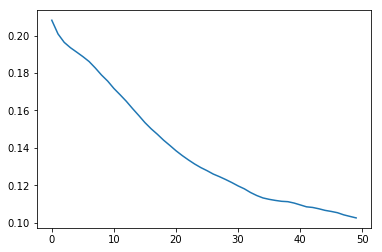

In [15]:
adam_model = model_trainer(
    dl=train_dl,
    model=base_model,
    optimiser=optim_1,
    epochs=50,
    criterion=criterion,
)

In [16]:
def roc_scorer(loader, model, device):
    model.eval()
    preds, actuals = [],[]
    
    with torch.no_grad():
        for feats, target in loader:
            feats = feats.to(device)
            target = target.to(device)
            predictions = model.forward(feats)
            preds += predictions.tolist()
            actuals += target.tolist()
    
    # roc_calc
    roc_score = metrics.roc_auc_score(actuals, preds)
    
    model.train()
    return roc_score

In [17]:
roc_scorer(valid_dl, adam_model, device=DEVICE)

0.8294936461287504

### using RMSProp

In [18]:
base_model_2 = BaselineNet(input_size=200)

In [19]:
optim_2 = optim.RMSprop(base_model_2.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

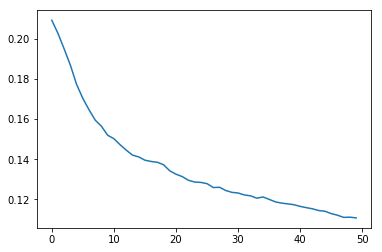

In [20]:
rmsProp_model = model_trainer(
    dl=train_dl,
    model=base_model_2,
    optimiser=optim_2,
    epochs=50,
    criterion=criterion,
)

In [21]:
roc_scorer(valid_dl, rmsProp_model, device=DEVICE)

0.8188872123051967

Adam optimiser has performed better than RMSProp on this dataset.